In [1]:
import tensorflow as tf
print(tf.__version__)

2.19.0


IMPORT LIBRARIES AND TOOLS

In [2]:
import os  # For directory and file operations or else to connect the os functionalities
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
import tensorflow
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
tr_df = '/kaggle/input/brain-tumor-mri-dataset/Training'

In [47]:
train_dir = "/content/data_preprocessed/Training"
valid_dir = "/content/data_preprocessed/Testing"

DATA PREPROCESSED FOLDER CODE

In [53]:
import os
from PIL import Image
import shutil

# ----------------- CONFIG -----------------
dataset_path = r'/content/brain_tumor_dataset'  # Main dataset folder containing 'Training' and 'Testing'
processed_path = r'data_preprocessed'  # Where processed images will be saved
image_size = (224, 224)  # Resize all images to this size
# ------------------------------------------

# Remove existing processed folder and create new
if os.path.exists(processed_path):
    shutil.rmtree(processed_path)
os.makedirs(processed_path)

# Process both Training and Testing folders
for subset in ['Training', 'Testing']:
    subset_folder = os.path.join(dataset_path, subset)
    processed_subset_folder = os.path.join(processed_path, subset)
    os.makedirs(processed_subset_folder, exist_ok=True)

    # Iterate through class subfolders
    for class_name in os.listdir(subset_folder):
        class_folder = os.path.join(subset_folder, class_name)
        if not os.path.isdir(class_folder):
            continue  # Skip files

        # Create class folder in processed dataset
        processed_class_folder = os.path.join(processed_subset_folder, class_name)
        os.makedirs(processed_class_folder, exist_ok=True)

        # Process each image
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            try:
                img = Image.open(img_path).convert('RGB')  # Convert grayscale to RGB
                img = img.resize(image_size)  # Resize
                save_path = os.path.join(processed_class_folder, img_name)
                img.save(save_path)
            except Exception as e:
                print(f"Skipped {img_path}, reason: {e}")

print("Dataset preprocessing complete! ✅")
print(f"Processed dataset is ready at: {processed_path}")


Dataset preprocessing complete! ✅
Processed dataset is ready at: data_preprocessed


CONVERSION CODE FORM ZIP TO NORMAL

In [5]:
import zipfile
import os

zip_path ="archive.zip"
extract_path = "brain_tumor_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

LOAD DATASET

In [54]:
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# -----------------------------
# Directories for training and testing data
# -----------------------------
train_dir = '/content/data_preprocessed/Training'
test_dir = '/content/data_preprocessed/Testing'

# -----------------------------
# Load and shuffle the train data
# -----------------------------
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

# Shuffle before splitting
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

# Split training into 80% train and 20% validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths,
    train_labels,
    test_size=0.2,           # 80-20 split
    stratify=train_labels,   # preserve class distribution
    random_state=42
)

# -----------------------------
# Load and shuffle the test data
# -----------------------------
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

# -----------------------------
# Print summary
# -----------------------------
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Testing samples: {len(test_paths)}")


Training samples: 4569
Validation samples: 1143
Testing samples: 1311


DATA VISULIZATION

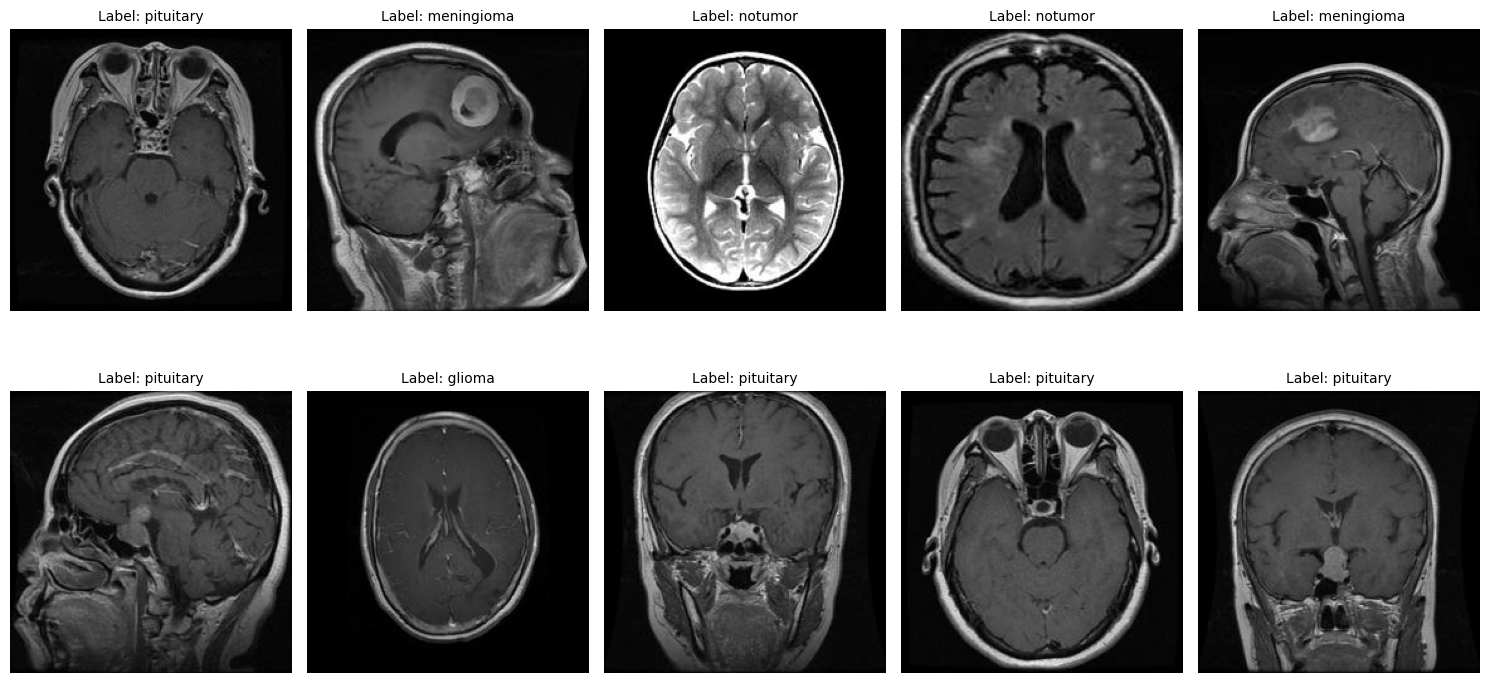

In [55]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


IMAGE PREPROCESSING

In [56]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

TRAINING MODEL

In [79]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(224, 224),batch_size=32)
val_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(224, 224),batch_size=32)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [80]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# ---------------- MODEL ARCHITECTURE ----------------
IMAGE_SIZE = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse'  # gives integer labels
)
test_ds = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse'
)

# Now compute class weights

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)
class_weights = dict(enumerate(class_weights))




base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                   include_top=False,
                   weights='imagenet')

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(os.listdir(train_dir)), activation='softmax')(x)  # Number of classes

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Changed from 0.0001 to 0.00001
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


# ---------------- CALLBACKS ----------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ---------------- TRAINING ----------------
batch_size = 32
epochs = 20  # Increased epoch size
steps = int(len(train_paths) / batch_size)

history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    validation_data=val_ds,
    steps_per_epoch=steps,
    callbacks=[early_stop]
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 479ms/step - loss: 0.9433 - sparse_categorical_accuracy: 0.6404 - val_loss: 133.7755 - val_sparse_categorical_accuracy: 0.3867
Epoch 2/20
 37/142 ━━━━━━━━━━━━━━━━━━━━ 29s 283ms/step - loss: 0.3475 - sparse_categorical_accuracy: 0.8751

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - loss: 0.3516 - sparse_categorical_accuracy: 0.8763 - val_loss: 166.4848 - val_sparse_categorical_accuracy: 0.3844
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 337ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9015 - val_loss: 173.0187 - val_sparse_categorical_accuracy: 0.4073
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - loss: 0.2325 - sparse_categorical_accuracy: 0.9218 - val_loss: 166.0955 - val_sparse_categorical_accuracy: 0.3791


TRAIN AND VALID PLOT

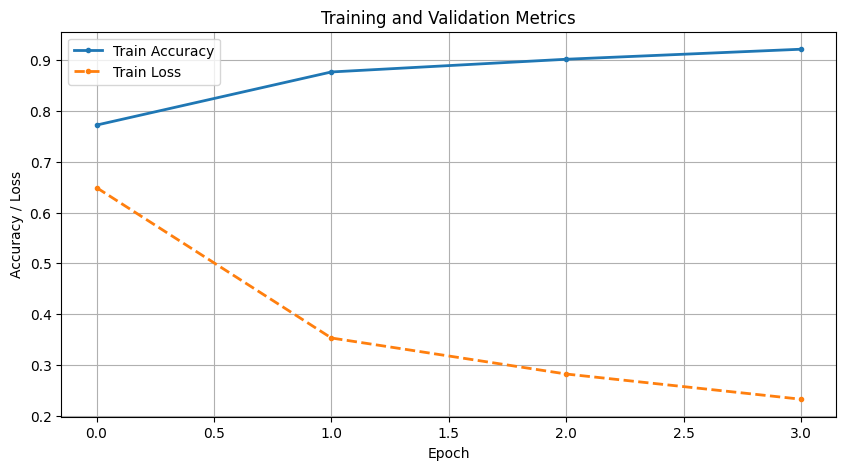

In [81]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(10,5))
plt.grid(True)

# Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], '.-', label='Train Accuracy', linewidth=2)

# Loss
plt.plot(history.history['loss'], '.--', label='Train Loss', linewidth=2)

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()


Model Confusion Plot

In [90]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
test_dir = 'data_preprocessed/Testing'  # Path to your test dataset folder
IMAGE_SIZE = (224, 224)                 # VGG16 input size

# ---------------- LOAD TEST DATA ----------------
# Use flow_from_directory to ensure correct class indices
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode='sparse',
    shuffle=False
)

# Extract file paths and true labels
test_paths = test_generator.filepaths
test_labels_encoded = test_generator.classes  # Encoded according to training class_indices

# ---------------- PREPROCESS FUNCTION ----------------
def load_and_preprocess_images(image_paths, target_size=(224,224)):
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0         # Normalize
        images.append(img_array)
    return np.array(images)

# Load and preprocess all test images
test_images_resized = load_and_preprocess_images(test_paths, target_size=IMAGE_SIZE)

# ---------------- PREDICTION ----------------
# If your model is already loaded in 'model'
test_predictions = model.predict(test_images_resized)
y_pred_classes = np.argmax(test_predictions, axis=1)

# ---------------- CLASSIFICATION REPORT ----------------
print("Classification Report:")
print(classification_report(test_labels_encoded, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.71      0.91      0.80       300
  meningioma       0.81      0.54      0.65       306
     notumor       0.91      0.91      0.91       405
   pituitary       0.86      0.90      0.88       300

    accuracy                           0.82      1311
   macro avg       0.82      0.82      0.81      1311
weighted avg       0.83      0.82      0.82      1311



CONFUSION MATRIX

Confusion Matrix:
[[273  22   2   3]
 [ 73 165  33  35]
 [ 20   9 369   7]
 [ 19   7   3 271]]


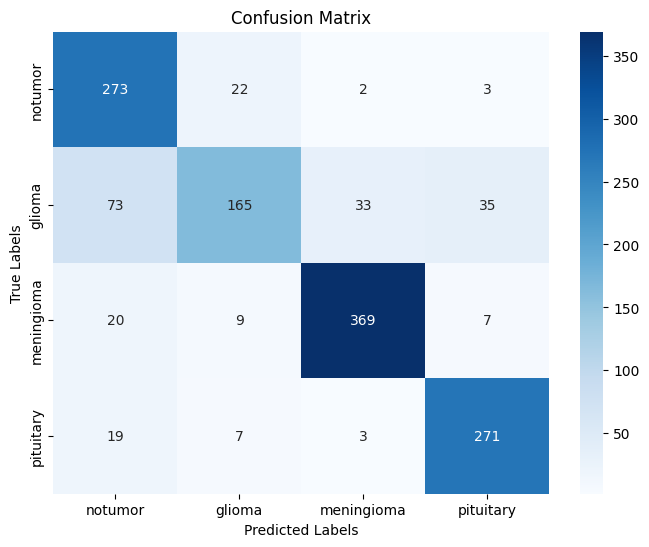

In [91]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ROC CURVE PLOT

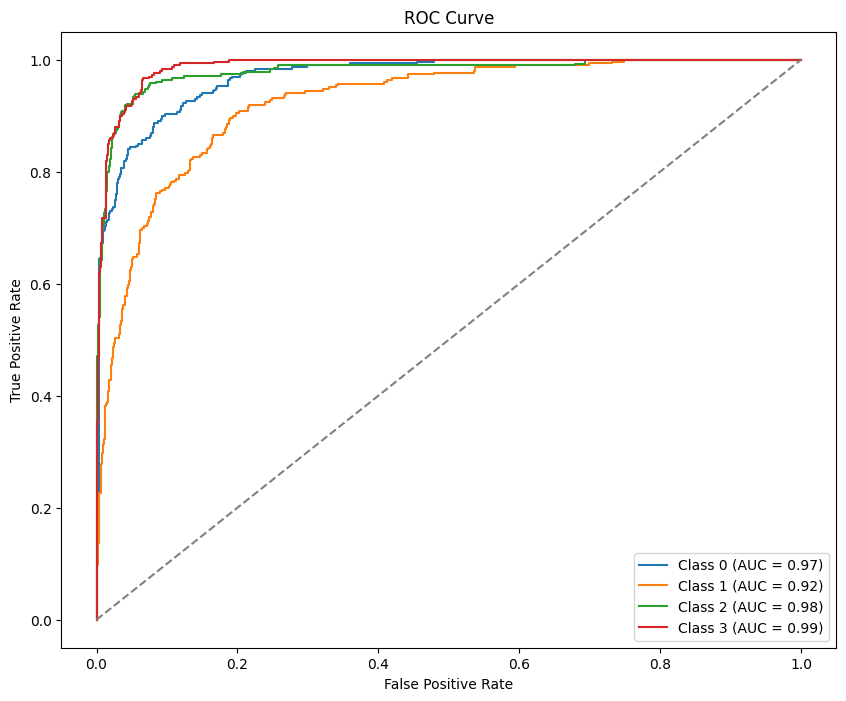

In [96]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Save & Load Model

In [92]:
model.save('model_new2.keras')

In [95]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model_new2.keras')